I'm going to try and download the Kages and LEGACY data from Vizier using ADQL, and combine them into a single array.

In [1]:
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")
import seaborn as sns
import pylab as plt
import numpy as np
import pandas as pd

In [2]:
from tap import TAPVizieR as tv
from tap import QueryStr

- Get all important information from both Legacy Tables
- Get the same information from Kages tables

# LEGACY Stars (66)
## We will use the BASTA model parameters

### Table 3, Paper 2: Global Seismic & Spectroscopic Properties
We will take all our global properties from this catalogue

In [3]:
adql = QueryStr("""
select 
    obs.KIC, obs.numax, obs."E_numax" as enumax, obs."<dnu>" as dnu, obs."E_<dnu>" as ednu,
    obs.Teff, obs."e_Teff" as eTeff, obs."[Fe/H]" as feh, obs."e_[Fe/H]" as efeh
from 
    "J/ApJ/835/173/table3" as obs
""")

vizier = tv()
legacyobs = vizier.query(adql).to_pandas()

*ADQL query*
```mysql

SELECT
    obs.KIC, obs.numax, obs."E_numax" AS enumax, obs."<dnu>" AS dnu, obs."E_<dnu>" AS ednu,
    obs.Teff, obs."e_Teff" AS eTeff, obs."[Fe/H]" AS feh, obs."e_[Fe/H]" AS efeh
FROM
    "J/ApJ/835/173/table3" AS obs

```

## Table 4, Paper 2: BASTA model output
We will take preliminary Masses, Radii, Logg and Ages from the BASTA fits in this catalogue

In [4]:
adql = QueryStr("""
select 
    modl.KIC,
    modl.Mass as modmass, modl."E_Mass" as upmodmass, modl."e_Mass" as lomodmass,
    modl.Rad as modrad, modl."E_Rad" as upmodrad, modl."e_Rad" as lomodrad,
    modl."log(g)" as modlogg, modl."E_log(g)" as upmodlogg, modl."e_log(g)" as lomodlogg,
    modl.Age as age, modl."E_Age" as upage, modl."e_Age" as loage 

from
    "J/ApJ/835/173/table4" as modl
where
    modl.Pipe ='BASTA'
""")

vizier = tv()
legacymodels = vizier.query(adql).to_pandas()

*ADQL query*
```mysql

SELECT
    modl.KIC,
    modl.Mass AS modmass, modl."E_Mass" AS upmodmass, modl."e_Mass" AS lomodmass,
    modl.Rad AS modrad, modl."E_Rad" AS upmodrad, modl."e_Rad" AS lomodrad,
    modl."log(g)" AS modlogg, modl."E_log(g)" AS upmodlogg, modl."e_log(g)" AS lomodlogg,
    modl.Age AS age, modl."E_Age" AS upage, modl."e_Age" AS loage

FROM
    "J/ApJ/835/173/table4" AS modl
WHERE
    modl.Pipe ='BASTA'

```

### Auxiliary table: Table 1, Paper 1: Parameters for studied stars
From this catalogue we will take the Kepler magnitude, Category, vsini, and sources on atmospheric parameters.
Note that the $\nu_{\rm max}$ and $\Delta\nu$ values in this catalogue differ slightly to those in Paper 2. We will use the values from Paper 2.

In [5]:
adql = QueryStr("""
select 
    aux.KIC, aux.Name, aux.Kpmag, aux.Cat, aux.r_Teff as Teffsource, 
    aux."r_[Fe/H]" as fehsource, aux.vsini, aux.e_vsini as evsini

from
    "J/ApJ/835/172/table1" as aux
""")

vizier = tv()
aux = vizier.query(adql).to_pandas()

aux.KIC = pd.to_numeric(aux['KIC'].str.decode("utf-8"))
aux.Name = aux.Name.str.decode("utf-8")
aux.Cat = aux.Cat.str.decode("utf-8")

*ADQL query*
```mysql

SELECT
    aux.KIC, aux.Name, aux.Kpmag, aux.Cat, aux.r_Teff AS Teffsource,
    aux."r_[Fe/H]" AS fehsource, aux.vsini, aux.e_vsini AS evsini

FROM
    "J/ApJ/835/172/table1" AS aux

```

In [6]:
legacy = legacyobs.merge(legacymodels, on='KIC', how='left')
legacy = legacy.merge(aux[['KIC','vsini','evsini']], on='KIC',how='left')

In [7]:
legacy.head(5)

,KIC,numax,enumax,dnu,ednu,Teff,eTeff,feh,efeh,modmass,...,upmodrad,lomodrad,modlogg,upmodlogg,lomodlogg,age,upage,loage,vsini,evsini
0,1435467,1406.7,6.3,70.369,0.034,6326,77,0.01,0.1,1.3189,...,0.018,0.021,4.0997,0.0088,0.0088,3.0164,0.4951,0.3513,11.9,0.5
1,2837475,1557.6,8.2,75.729,0.041,6614,77,0.01,0.1,1.4291,...,0.015,0.018,4.1635,0.0066,0.0066,1.6270,0.1118,0.1757,23.3,0.5
2,3427720,2737.0,10.7,120.068,0.031,6045,77,-0.06,0.1,1.1080,...,0.009,0.009,4.3868,0.0044,0.0055,2.2339,0.2396,0.2396,2.9,0.5
3,3456181,970.0,8.3,52.264,0.041,6384,77,-0.15,0.1,1.4975,...,0.027,0.027,3.9490,0.0088,0.0077,2.0901,0.1278,0.1278,8.5,0.5
4,3632418,1166.8,3.0,60.704,0.019,6193,77,-0.12,0.1,1.4082,...,0.021,0.024,4.0238,0.0077,0.0077,2.6331,0.1757,0.1757,8.5,0.5


# Kages
## We will use the BASTA model parameters

### Table 3, Paper 1
We will take the model parameters as well as the atmospheric parameters from here.

In [8]:
adql = QueryStr("""
select 
    obs.KIC, obs.Teff, obs."e_Teff" as eTeff, obs."[Fe/H]" as feh, obs."e_[Fe/H]" as efeh,
    obs.Mass as modmass, obs."E_Mass" as upmodmass, obs."e_Mass" as lomodmass,
    obs.Radius as modrad, obs."E_Radius" as upmodrad, obs."e_Radius" as lomodrad,
    obs.logg as modlogg, obs."E_logg" as upmodlogg, obs."e_logg" as lomodlogg,
    obs.Age as age, obs."E_Age" as upage, obs."e_Age" as loage
from 
    "J/MNRAS/452/2127/table3" as obs
""")

vizier = tv()
kagesmodels = vizier.query(adql).to_pandas()

*ADQL query*
```mysql

SELECT
    obs.KIC, obs.Teff, obs."e_Teff" AS eTeff, obs."[Fe/H]" AS feh, obs."e_[Fe/H]" AS efeh,
    obs.Mass AS modmass, obs."E_Mass" AS upmodmass, obs."e_Mass" AS lomodmass,
    obs.Radius AS modrad, obs."E_Radius" AS upmodrad, obs."e_Radius" AS lomodrad,
    obs.logg AS modlogg, obs."E_logg" AS upmodlogg, obs."e_logg" AS lomodlogg,
    obs.Age AS age, obs."E_Age" AS upage, obs."e_Age" AS loage
FROM
    "J/MNRAS/452/2127/table3" AS obs

```

### Table 1, Paper 2
This table is not on Vizier, so we shall read it in. The $vsin(i)$ values are not reported in the publication of Davies+2016, but have been received via private communication.

In [9]:
kagesseis = pd.read_csv('kagesIIdata.dat', 
                      usecols=['KIC','num','snum','dnu','sdnu','vsini','svsini'],
                      sep='\s+').rename(columns={'num':'numax',
                                                'snum':'enumax',
                                                'sdnu':'ednu',
                                                'svsini':'evsini'})

In [10]:
kages = kagesmodels.merge(kagesseis, on='KIC',sort='left')

In [11]:
kages.head(5)

,KIC,Teff,eTeff,feh,efeh,modmass,upmodmass,lomodmass,modrad,upmodrad,...,lomodlogg,age,upage,loage,numax,enumax,dnu,ednu,vsini,evsini
0,3425851,6343,85,-0.04,0.10,1.178,0.049,0.049,1.360,0.015,...,0.008,3.32,0.85,0.64,2038,60,92.60,1.50,9.5,0.5
1,3544595,5669,75,-0.18,0.10,0.899,0.009,0.009,0.916,0.006,...,0.003,6.63,0.62,0.57,3366,81,145.77,0.45,2.0,0.5
2,3632418,6305,50,-0.03,0.10,1.408,0.021,0.030,1.902,0.018,...,0.004,2.60,0.16,0.16,1153,32,60.86,0.55,7.7,1.0
3,4141376,6134,91,-0.24,0.10,1.019,0.021,0.030,1.039,0.009,...,0.004,3.27,0.59,0.64,2928,97,128.80,1.30,3.5,0.5
4,4143755,5622,106,-0.40,0.11,0.918,0.021,0.030,1.414,0.012,...,0.002,11.27,1.50,1.35,1458,57,77.20,1.30,2.2,0.6


# Now lets combine them!
## We'll add a Legacy/Kages (L/K) source label also

In [12]:
legacy['source'] = ['L'] * len(legacy)
kages['source'] = ['K'] * len(kages)
malatium = legacy.merge(kages, on='KIC', how='outer')

Note that there are 4 duplicates across these catalogues. These stars are:
* 3632418
* 9414417
* 9955598	
* 10963065

In these cases we preserve the values reported in LEGACY and not in Kages.

In [13]:
malatium = legacy.append(kages).drop_duplicates('KIC', keep='first')

In [14]:
malatium.to_csv('malatium.csv')
malatium['KIC'].to_csv('targetlist.txt',index=False)
print('Our final sample contains: {} stars'.format(len(malatium)))

Our final sample contains: 95 stars


# Lets make some fun plots!

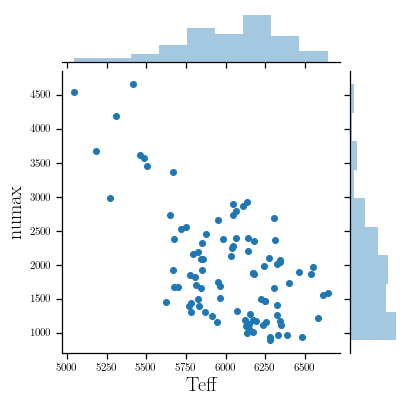

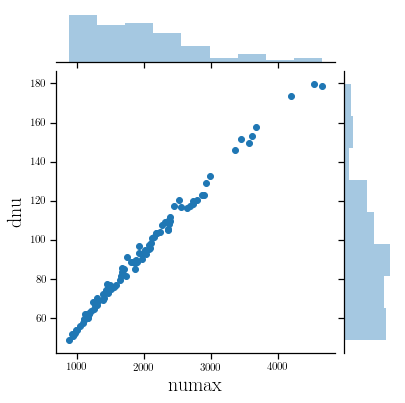

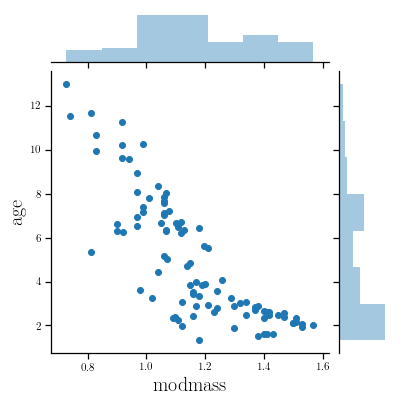

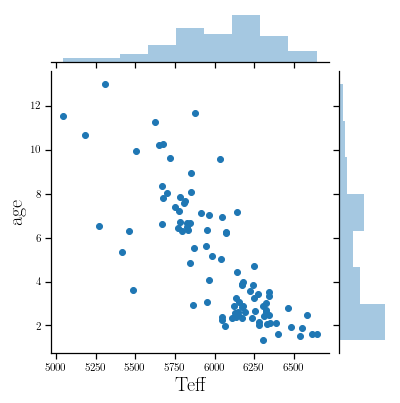

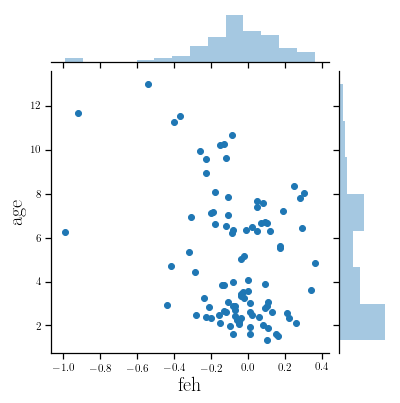

In [15]:
sns.set_context('notebook',rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":20})
sns.jointplot('Teff', 'numax', data=malatium)
sns.jointplot('numax','dnu',data=malatium)
sns.jointplot('modmass','age',data=malatium)
sns.jointplot('Teff','age',data=malatium)
sns.jointplot('feh','age',data=malatium)